In [ ]:
%cd /content

!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything

/content
Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1807, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 1807 (delta 9), reused 1 (delta 1), pack-reused 1789 (from 2)
Receiving objects: 100% (1807/1807), 155.84 MiB | 25.94 MiB/s, done.
Resolving deltas: 100% (830/830), done.
/content/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 11.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━

In [ ]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [ ]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [ ]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

--2024-12-17 08:33:07--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.51, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   202MB/s    in 13s     

2024-12-17 08:33:21 (184 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Image downloaded from url: https://cdn2.divan.ru/img/v1/tES-6TcMsgV7dLTpiOjkogJNs8TR0B_yJNMpGczweV4/rs:fit:1920:1440:0:0/g:ce:0:0/bg:ffffff/q:85/czM6Ly9kaXZhbi9ja2VkaXRvci93aWtpLWFydGljbGUvMjQ1My82MzhkZjUyZmYwOGQ2LmpwZw.jpg and saved to: assets/inpaint_demo.jpg.


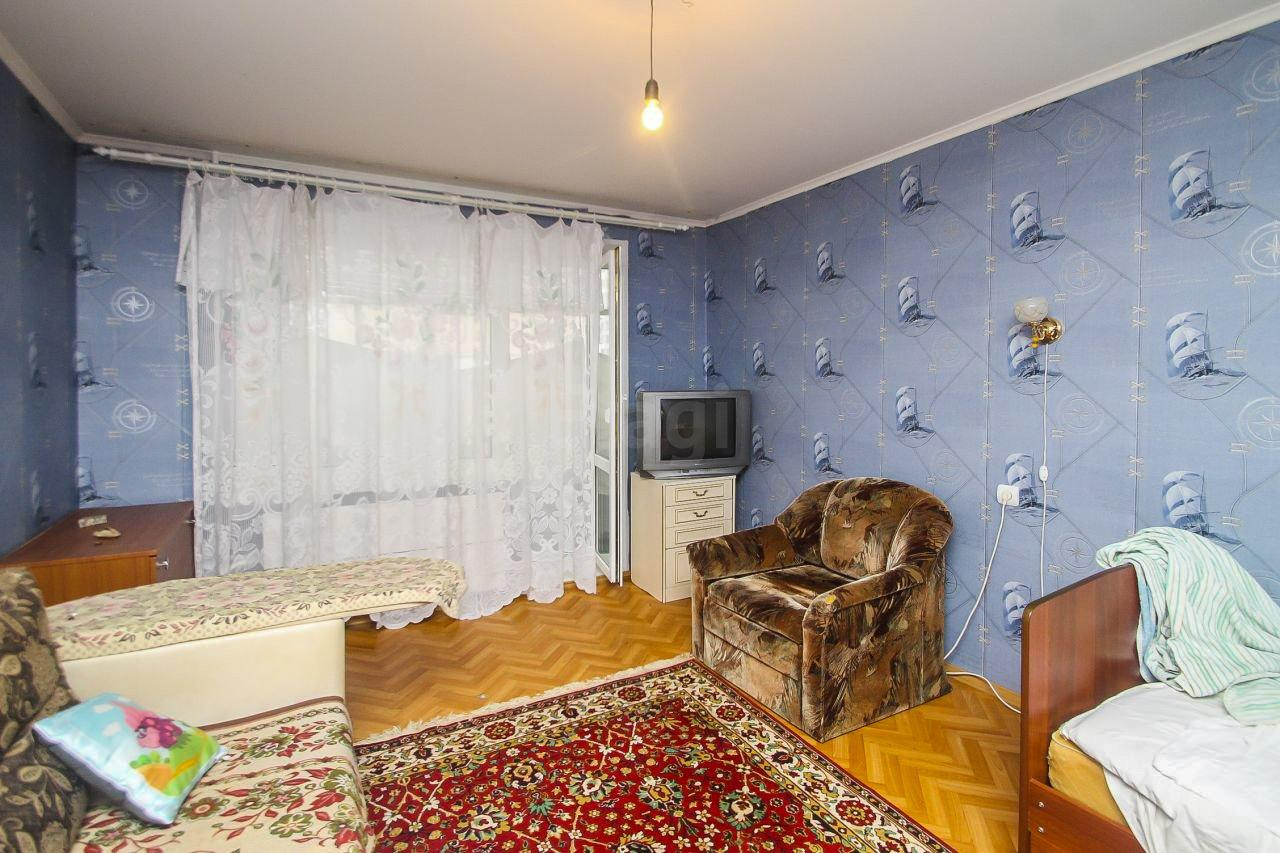

In [ ]:
# Load image
def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))


local_image_path = "assets/inpaint_demo.jpg"
image_url = "https://cdn2.divan.ru/img/v1/tES-6TcMsgV7dLTpiOjkogJNs8TR0B_yJNMpGczweV4/rs:fit:1920:1440:0:0/g:ce:0:0/bg:ffffff/q:85/czM6Ly9kaXZhbi9ja2VkaXRvci93aWtpLWFydGljbGUvMjQ1My82MzhkZjUyZmYwOGQ2LmpwZw.jpg"

download_image(image_url, local_image_path)
image_source, image = load_image(local_image_path)
Image.fromarray(image_source)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from groundingdino.util.inference import predict

# detect object using Grounding DINO
def detect(image, text_prompt, model, box_threshold=0.3, text_threshold=0.25):
    # Получаем предсказания из модели
    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=text_prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )

    return boxes, logits, phrases


In [ ]:
detected_boxes, logit, phrase= detect(image, text_prompt="chair", model=groundingdino_model)

In [ ]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    # annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(mask_image_pil)

In [ ]:
# import numpy as np
# from PIL import Image

# def draw_mask(mask, image, random_color=True):
#     # Convert mask and image to NumPy arrays
#     mask = mask.cpu().numpy()
#     image = image.cpu().numpy()

#     # Transpose image from (C, H, W) to (H, W, C) if necessary
#     if image.shape[0] == 3:  # If channel-first format
#         image = np.transpose(image, (1, 2, 0))  # (H, W, C)

#     # Generate a random color or use a predefined one
#     if random_color:
#         color = np.random.randint(0, 256, size=(3,), dtype=np.uint8)  # Random RGB color
#     else:
#         color = np.array([255, 0, 0], dtype=np.uint8)  # Red as default

#     h, w = mask.shape
#     mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

#     # Convert arrays to PIL images
#     annotated_frame_pil = Image.fromarray(image.astype(np.uint8)).convert("RGBA")
#     mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")

#     # Overlay mask on the original image
#     annotated_frame_with_mask = Image.alpha_composite(annotated_frame_pil, mask_image_pil)
#     return np.array(annotated_frame_with_mask)


In [ ]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)

In [ ]:
segmented_frame_masks.shape

torch.Size([2, 1, 853, 1280])

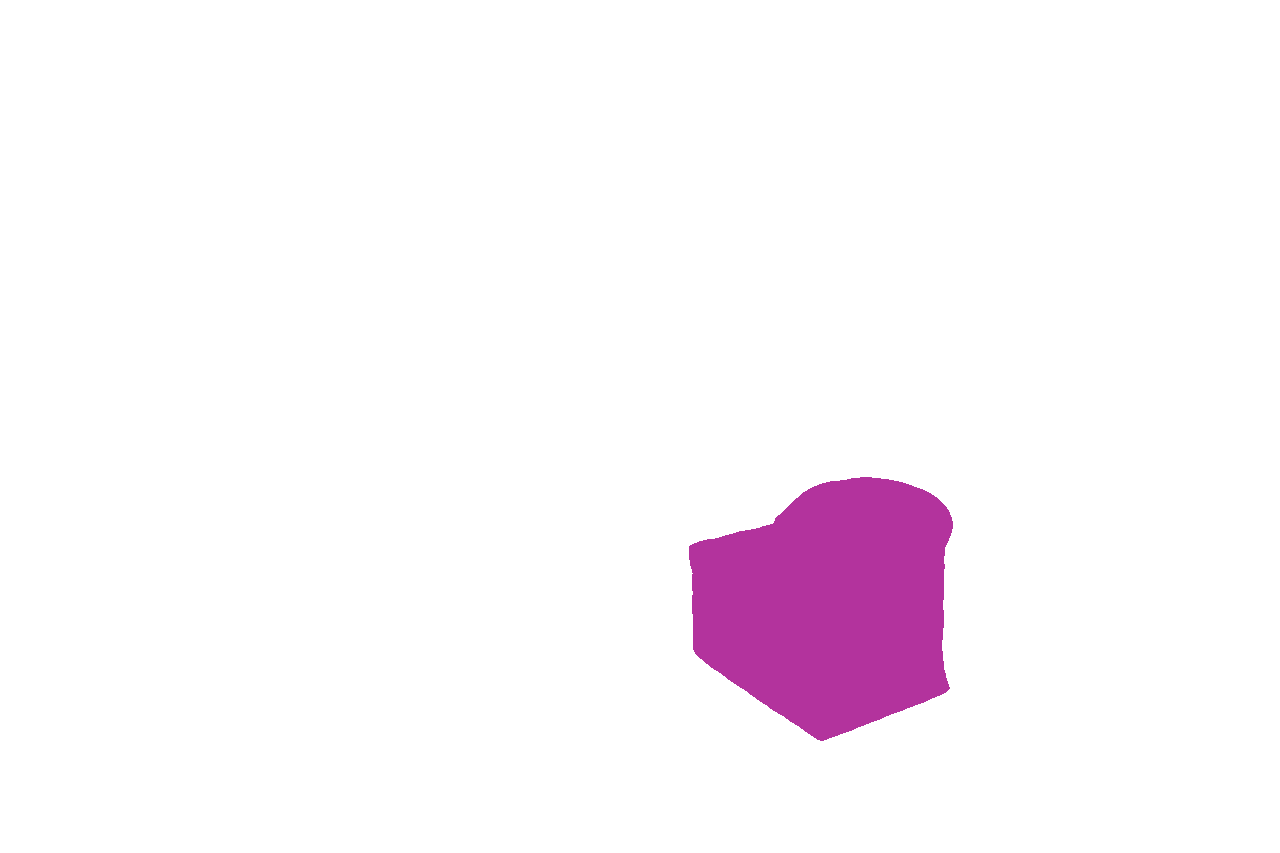

In [ ]:
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], image)
Image.fromarray(annotated_frame_with_mask)

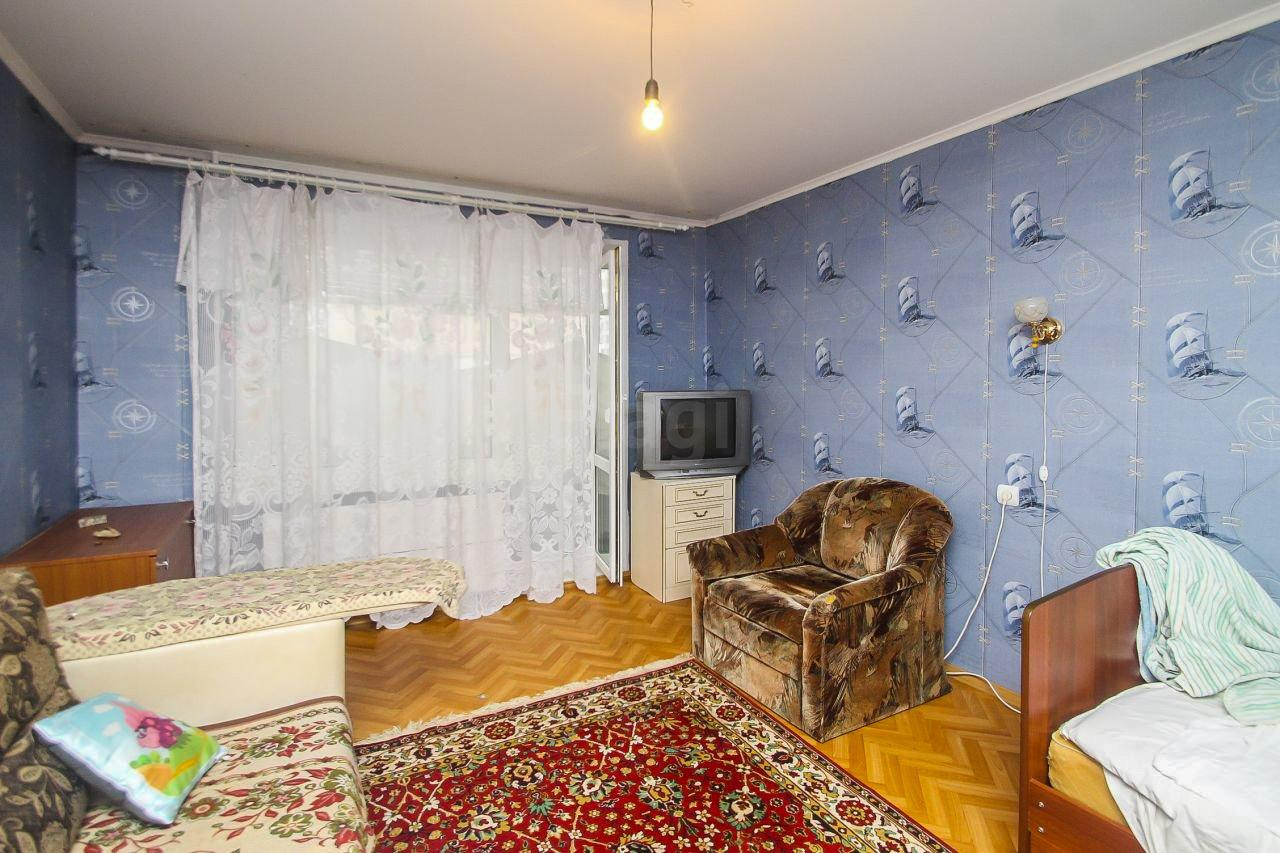

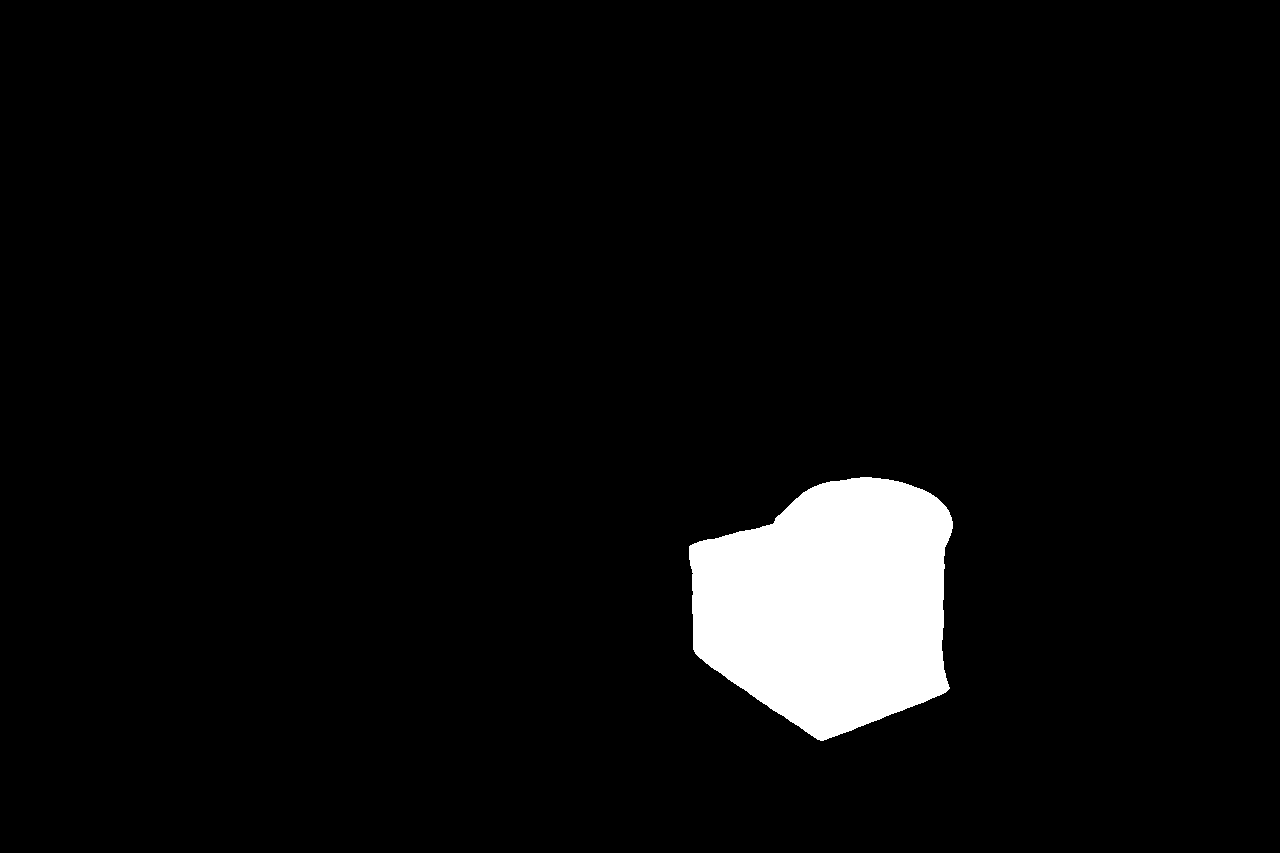

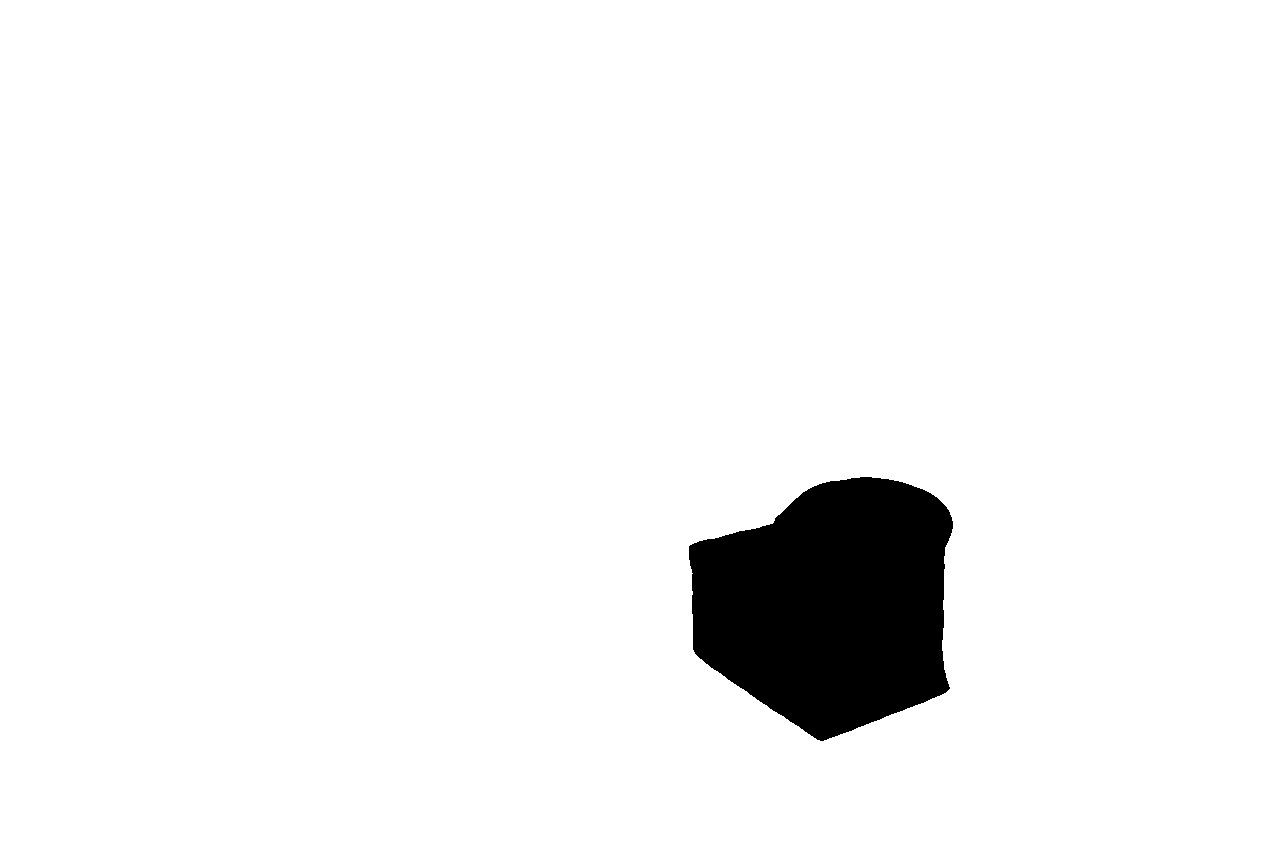

In [ ]:
# create mask images
mask = segmented_frame_masks[0][0].cpu().numpy()
inverted_mask = ((1 - mask) * 255).astype(np.uint8)


image_source_pil = Image.fromarray(image_source)
image_mask_pil = Image.fromarray(mask)
inverted_image_mask_pil = Image.fromarray(inverted_mask)


display(*[image_source_pil, image_mask_pil, inverted_image_mask_pil])

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 53.5M/53.5M [00:00<00:00, 122MB/s]


100%|██████████| 198k/198k [00:00<00:00, 377kB/s]


image 1/1 /content/czM6Ly9kaXZhbi9ja2VkaXRvci93aWtpLWFydGljbGUvMjQ1My82MzhkZjUyZmYwOGQ2LmpwZw.jpg: 448x640 1 chair, 3 couchs, 1 bed, 1 tv, 112.8ms
Speed: 11.5ms preprocess, 112.8ms inference, 1139.8ms postprocess per image at shape (1, 3, 448, 640)


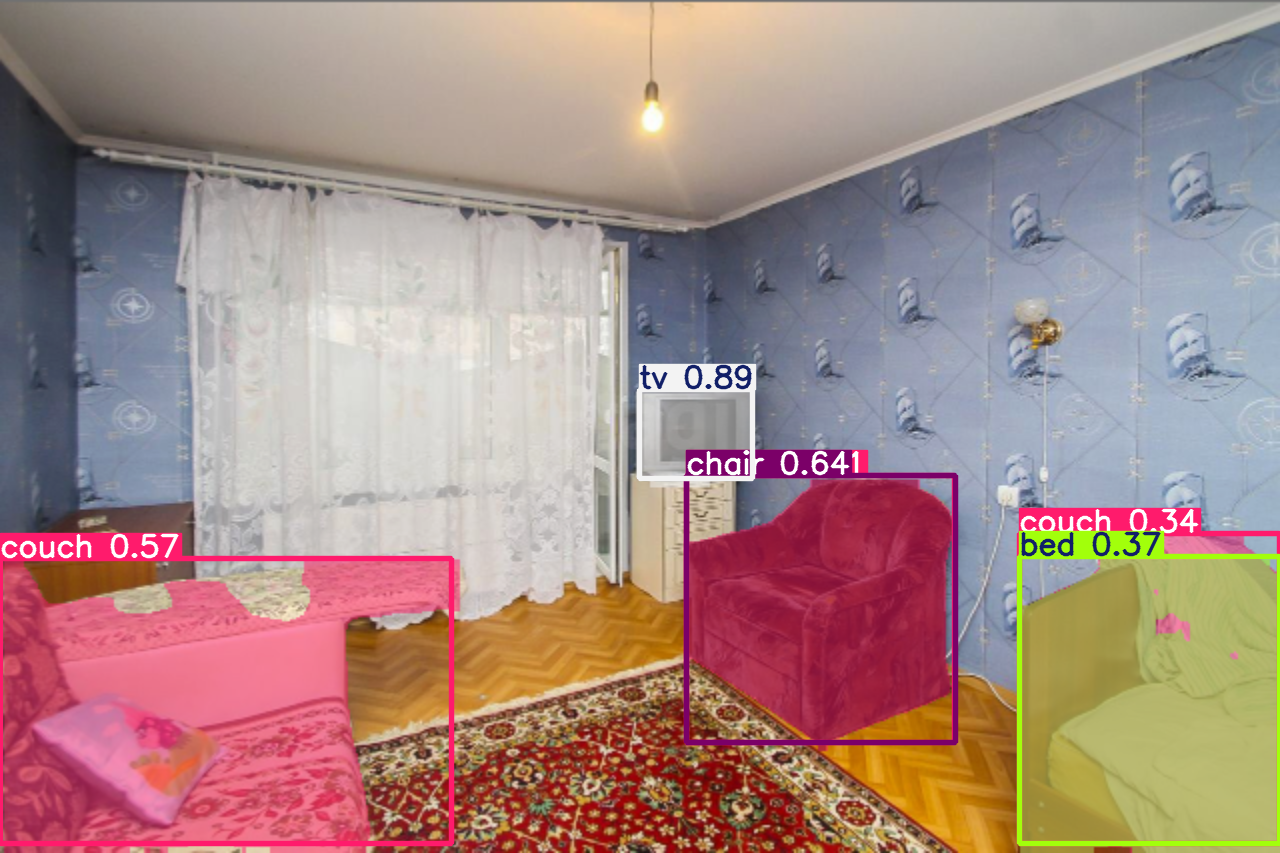

In [ ]:
from ultralytics import YOLO

# Загрузить модель сегментации
model = YOLO("yolo11l-seg.pt")   # загрузить официальную модель сегментации

# Сделать предсказание
results = model("https://cdn2.divan.ru/img/v1/tES-6TcMsgV7dLTpiOjkogJNs8TR0B_yJNMpGczweV4/rs:fit:1920:1440:0:0/g:ce:0:0/bg:ffffff/q:85/czM6Ly9kaXZhbi9ja2VkaXRvci93aWtpLWFydGljbGUvMjQ1My82MzhkZjUyZmYwOGQ2LmpwZw.jpg")  # предсказание на изображении

# Process results
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    result.show()  # display to screen
    # result.save(filename="result.jpg")  # save to disk

In [ ]:
masks.shape, boxes.shape

(torch.Size([6, 448, 640]), torch.Size([6, 6]))

In [ ]:
boxes.xywh, boxes.xywhn, boxes.xyxy, boxes.xyxyn

(tensor([[ 695.9008,  433.7821,  113.4896,   89.3139],
         [ 820.5392,  609.3101,  269.0015,  266.7144],
         [ 226.0272,  700.9893,  451.4951,  285.7714],
         [ 820.4557,  609.0631,  268.6768,  266.6943],
         [1149.3169,  699.6752,  259.7195,  286.9565],
         [1149.4019,  688.7333,  259.8375,  310.0427]], device='cuda:0'),
 tensor([[0.5437, 0.5085, 0.0887, 0.1047],
         [0.6410, 0.7143, 0.2102, 0.3127],
         [0.1766, 0.8218, 0.3527, 0.3350],
         [0.6410, 0.7140, 0.2099, 0.3127],
         [0.8979, 0.8203, 0.2029, 0.3364],
         [0.8980, 0.8074, 0.2030, 0.3635]], device='cuda:0'),
 tensor([[6.3916e+02, 3.8913e+02, 7.5265e+02, 4.7844e+02],
         [6.8604e+02, 4.7595e+02, 9.5504e+02, 7.4267e+02],
         [2.7960e-01, 5.5810e+02, 4.5177e+02, 8.4387e+02],
         [6.8612e+02, 4.7572e+02, 9.5479e+02, 7.4241e+02],
         [1.0195e+03, 5.5620e+02, 1.2792e+03, 8.4315e+02],
         [1.0195e+03, 5.3371e+02, 1.2793e+03, 8.4375e+02]], device='cuda:0'),
 

In [ ]:
boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([62., 56., 57., 57., 59., 57.], device='cuda:0')
conf: tensor([0.8891, 0.6430, 0.5674, 0.4112, 0.3713, 0.3405], device='cuda:0')
data: tensor([[6.3916e+02, 3.8913e+02, 7.5265e+02, 4.7844e+02, 8.8914e-01, 6.2000e+01],
        [6.8604e+02, 4.7595e+02, 9.5504e+02, 7.4267e+02, 6.4296e-01, 5.6000e+01],
        [2.7960e-01, 5.5810e+02, 4.5177e+02, 8.4387e+02, 5.6736e-01, 5.7000e+01],
        [6.8612e+02, 4.7572e+02, 9.5479e+02, 7.4241e+02, 4.1119e-01, 5.7000e+01],
        [1.0195e+03, 5.5620e+02, 1.2792e+03, 8.4315e+02, 3.7135e-01, 5.9000e+01],
        [1.0195e+03, 5.3371e+02, 1.2793e+03, 8.4375e+02, 3.4046e-01, 5.7000e+01]], device='cuda:0')
id: None
is_track: False
orig_shape: (853, 1280)
shape: torch.Size([6, 6])
xywh: tensor([[ 695.9008,  433.7821,  113.4896,   89.3139],
        [ 820.5392,  609.3101,  269.0015,  266.7144],
        [ 226.0272,  700.9893,  451.4951,  285.7714],
        [ 820.4557,  609.0631,  268.6768, 

In [ ]:
# !pip install ultralytics

In [ ]:
def generate_image(image, mask, prompt, negative_prompt, pipe, seed):
  # resize for inpainting
  w, h = image.size
  in_image = image.resize((512, 512))
  in_mask = mask.resize((512, 512))

  generator = torch.Generator(device).manual_seed(seed)

  result = pipe(image=in_image, mask_image=in_mask, prompt=prompt, negative_prompt=negative_prompt, generator=generator)
  result = result.images[0]

  return result.resize((w, h))

  0%|          | 0/50 [00:00<?, ?it/s]

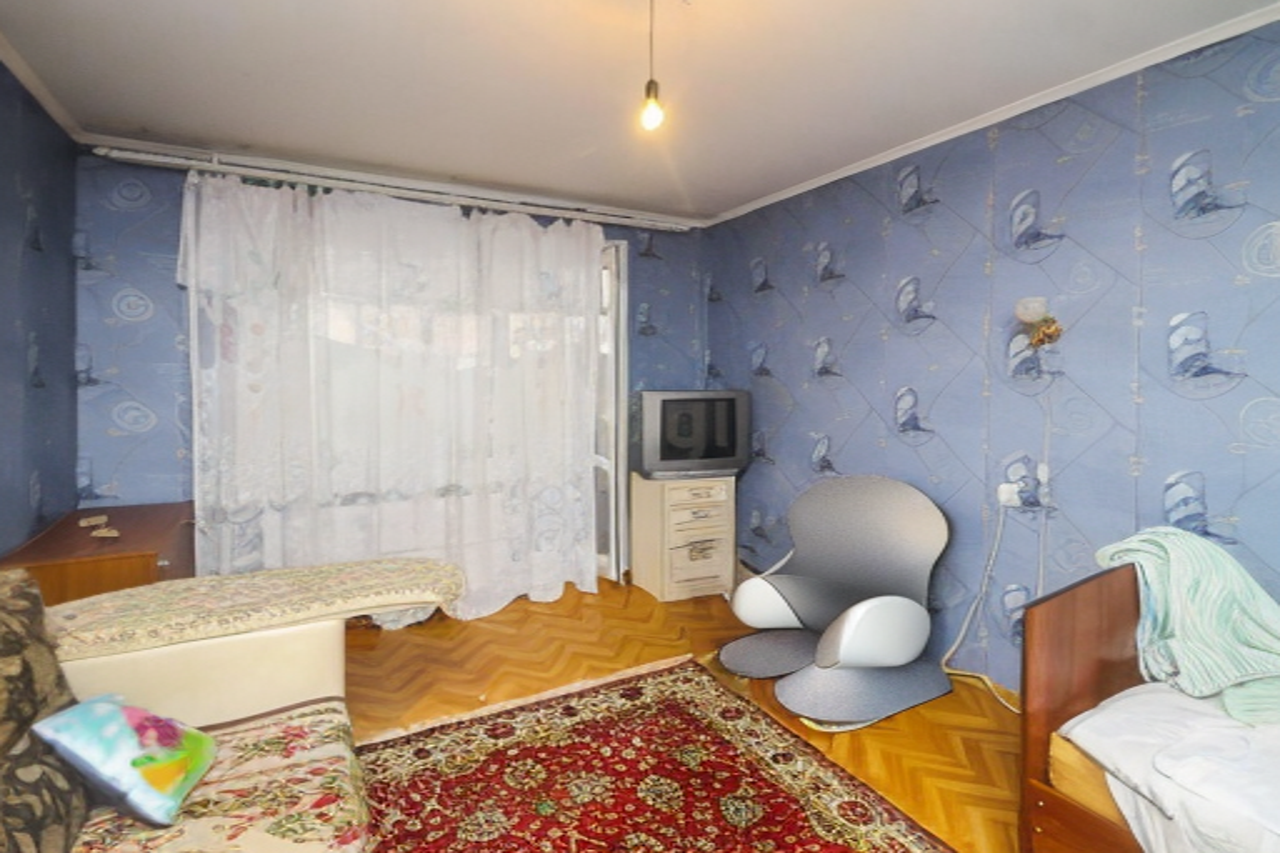

In [ ]:
prompt="A chair, high quality, detailed, modern, futuristic, with a lot of details, and a lot of colors."
negative_prompt="low resolution, ugly"
seed = 32 # for reproducibility

generated_image = generate_image(image=image_source_pil, mask=image_mask_pil, prompt=prompt, negative_prompt=negative_prompt, pipe=sd_pipe, seed=seed)
generated_image